In [1]:
import numpy as np
import pandas as pd 
from matplotlib import style
import matplotlib.pyplot as plt 
import seaborn as sns

style.use("ggplot")

%matplotlib inline

In [2]:
df = pd.read_csv("./data/penguins.csv").dropna()

In [3]:
df.columns

Index(['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass', 'Species'], dtype='object')

In [4]:
df = pd.concat([df,df,df,df]).reset_index()

In [5]:
X_pre = df[['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']].values
y = df['Species'].values

In [6]:
species_map = {
    0 : "Adelie",
    1 : "Gentoo",
    2 : "Chinstrap"
}

In [7]:
(
    X_pre.shape,
    y.shape
)

((1368, 4), (1368,))

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = StandardScaler().fit_transform(X_pre)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=0)

## Pytorch

In [10]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

In [11]:
X_tensor_train = torch.Tensor(X_train).float()
y_tensor_train = torch.Tensor(y_train).long()

dataset_train = td.TensorDataset(X_tensor_train,y_tensor_train)
train_loader = td.DataLoader(dataset_train, batch_size=20,
    shuffle=False, num_workers=1)


X_tensor_test = torch.Tensor(X_test).float()
y_tensor_test = torch.Tensor(y_test).long()

dataset_test = td.TensorDataset(X_tensor_test,y_tensor_test)
test_loader = td.DataLoader(dataset_test, batch_size=20,
    shuffle=False, num_workers=1)

In [12]:
_ , n_features = X.shape
n_classes = len(species_map)

In [13]:
n_features, n_classes

(4, 3)

In [14]:
hidden_layer_nodes = 16
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features= n_features,out_features=hidden_layer_nodes),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_nodes,out_features=hidden_layer_nodes),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_nodes,out_features=n_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self,X):
        X = self.layer_stack(X)
        return X
    
model = NeuralNet()
print(model)
    

NeuralNet(
  (layer_stack): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)


In [15]:
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    
    train_loss = 0
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = train_loss / (batch+1)
    return avg_loss
            
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        batch_count = 0
        for X, y in dataloader:
            
            batch_count += 1
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    avg_loss = test_loss/batch_count
    test_loss /= size
    correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return avg_loss
    
    


In [16]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer.zero_grad()

In [18]:
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

In [19]:
# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(train_loader,model,loss_fn, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(test_loader,model)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50


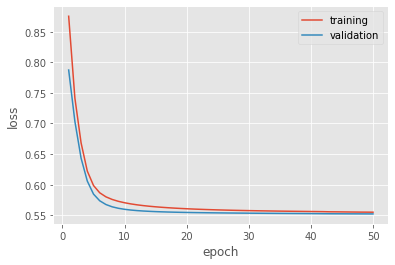

In [20]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


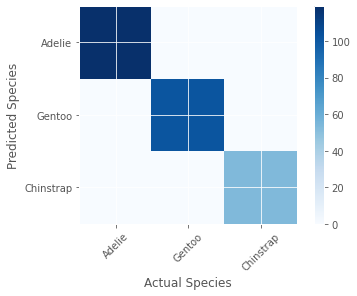

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(X_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(species_map))
plt.xticks(tick_marks, species_map.values(), rotation=45)
plt.yticks(tick_marks, species_map.values())
plt.xlabel("Actual Species")
plt.ylabel("Predicted Species")
plt.show()
